In [1]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv ../.env.local

In [40]:
import base64
from anthropic import Anthropic

import os
from pathlib import Path
import json

from utils import build_message_list, parse_json_response

In [3]:
client = Anthropic(
    api_key=os.environ.get('ANTHROPIC_API_KEY'),
)

MODEL_NAME = "claude-3-opus-20240229"

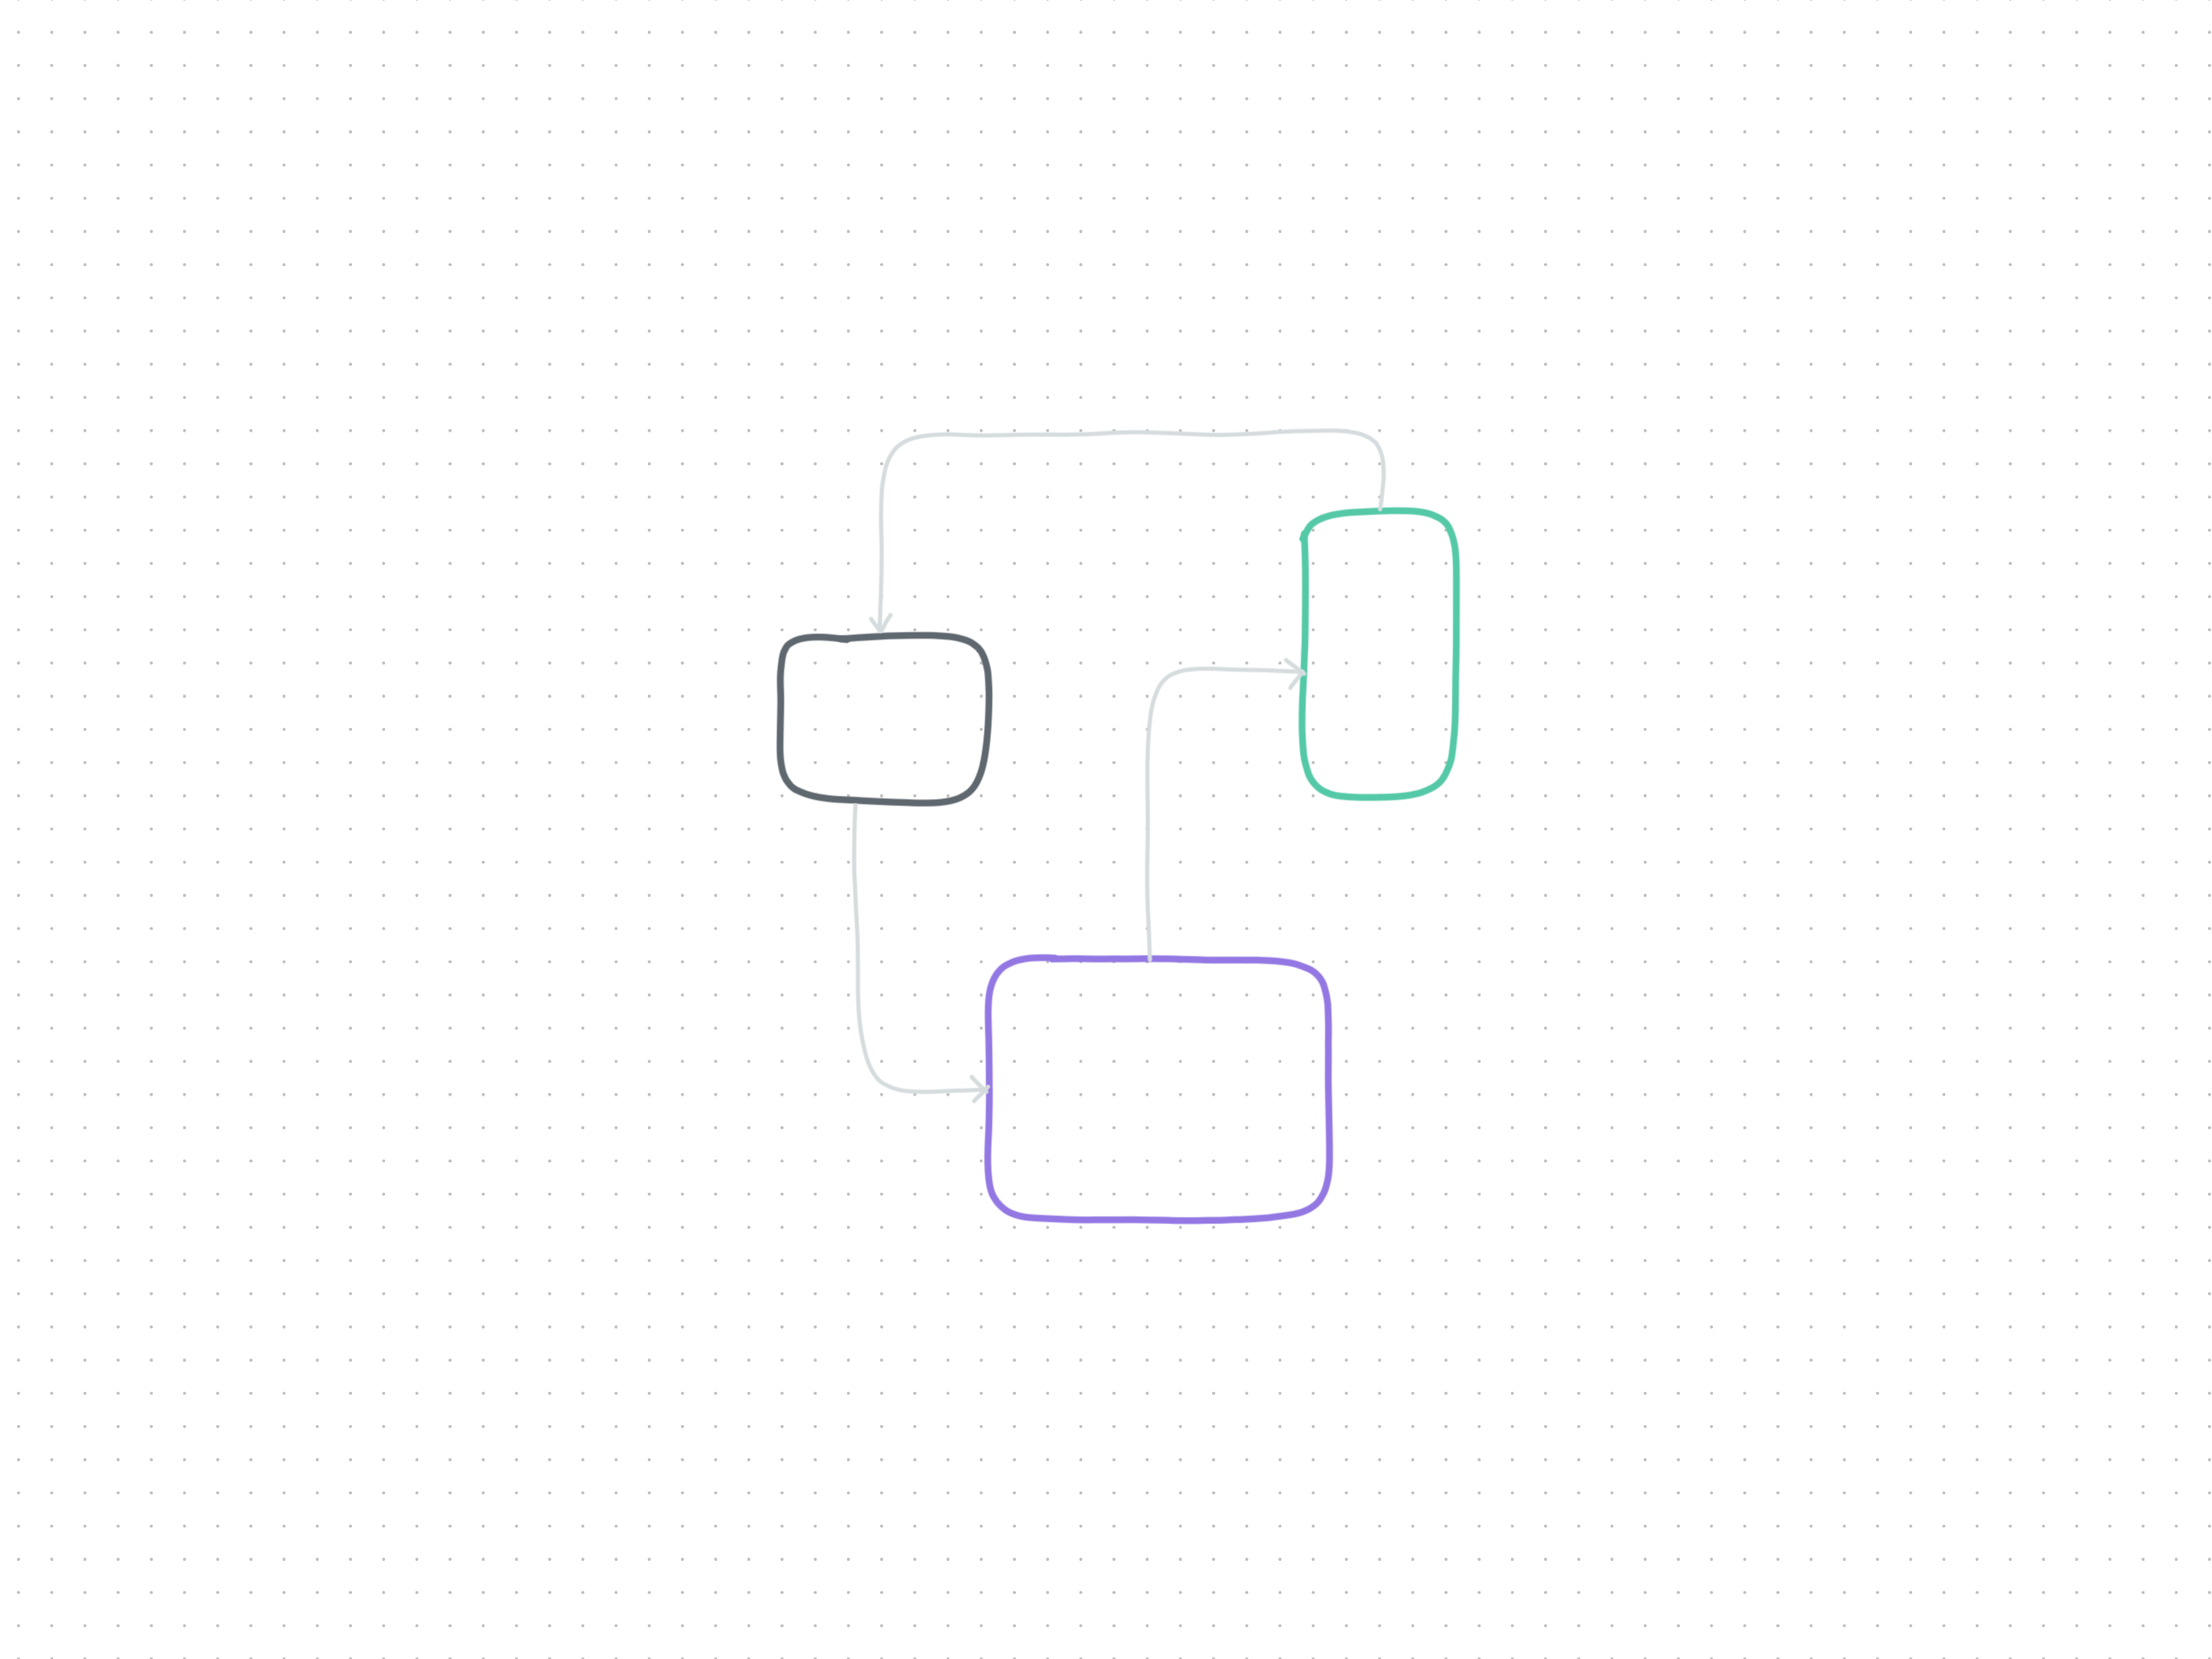

In [26]:
from IPython.display import Image

Image(filename='../data/colors.png') 

In [38]:
system_prompt = '''# Converting a Handwritten Sketch to JSON Canvas Format

As an AI engineer, your task is to convert a handwritten sketch of a prompt workflow into a JSON Canvas diagram. 
Follow these steps, writing out your thought process as you go along to ensure you don't miss any details:

1. **Identify nodes**: 
   - List out each text box in the sketch as a separate node
   - Note the text content and color of each node:
      - Red: `{"type":"text", ... , "color":"1"}`  
      - Orange: `{"type":"text", ... , "color":"2"}`
      - Yellow: `{"type":"text", ... , "color":"3"}`
      - Green: `{"type":"text", ... , "color":"4"}` 
      - Blue: `{"type":"text", ... , "color":"5"}`
      - Purple: `{"type":"text", ... , "color":"6"}`
   - Specify the position and size of each node using `"x"`, `"y"`, `"width"`, and `"height"` properties
   - Example node: `{"type":"text","text":"Hello world!","id":"abc123","x":100,"y":200,"width":250,"height":60}`

2. **Identify edges**:
   - Carefully examine the sketch to find ALL arrows connecting nodes 
   - Be sure to look for:
     - Arrows that may be smaller or lighter than others
     - Arrows that blend in with node borders or other lines
     - Arrows that cross or overlap other elements
   - For each arrow, clearly identify:  
     - The exact node the arrow starts from (the "from" node)
     - The exact node the arrow ends at (the "to" node)
   - Specify the "from" and "to" nodes by their unique `"id"` properties, not by position or text content
   - Double check that EVERY arrow in the sketch has a corresponding edge object
   - Example edge: `{"id":"def456","fromNode":"abc123","fromSide":"bottom","toNode":"ghi789","toSide":"top"}`

3. **Create the JSON Canvas object**:
   - Add a top-level `"nodes"` array containing all the node objects
   - Add a top-level `"edges"` array containing all the edge objects
   - Double check that EVERY node in the `"nodes"` array is referenced by at least one edge in the `"edges"` array
   - If a node does not have any edges, something was likely missed - recheck the sketch and add the missing edges
   - If there is a box drawn around some nodes in the sketch, add a group node that contains those nodes using the `"id"`, `"x"`, `"y"`, `"width"`, `"height"` and `"label"` properties

4. **Validate the diagram**:
   - Ensure there are no floating nodes - every node is connected to at least one other node
   - All green "metaprompt" nodes connect to either a system prompt or user prompt, but not both
   - All system prompts connect to a user prompt
   - All user prompts connect to an assistant response 
   - Add an assistant response node if one is missing

5. **Reformat and return the completed JSON Canvas**

Here is an example of what a small part of the completed JSON might look like:

```json
{
  "nodes":[
    {"type":"group","id":"abc123","x":-100,"y":-100,"width":400,"height":300,"label":"Example Workflow"},
    {"type":"text","text":"System prompt","id":"def456","x":20,"y":30,"width":200,"height":60,"color":"4"},
    {"type":"text","text":"User prompt","id":"ghi789","x":20,"y":120,"width":200,"height":60}
  ],
  "edges":[
    {"id":"jkl012", "fromNode":"def456","fromSide":"bottom","toNode":"ghi789","toSide":"top"}
  ]
}
```
'''

user_prompt = ''' The image is 2752 × 2064 pixels and contains a hand-drawn diagram of a prompt flow.
Carefully review the sketch and methodically build up the nodes and edges following these guidelines to create a complete and accurate JSON Canvas representation of the prompt flow diagram.'''

message_list = build_message_list('../data/colors.png', user_prompt)

response = client.messages.create(
    model=MODEL_NAME,
    max_tokens=2048,
    system=system_prompt,
    messages=message_list,
	temperature=0.0,
)
print(response.content[0].text)

Here is my thought process for converting the handwritten sketch into a JSON Canvas diagram:

1. Identify nodes:
   - There are 3 nodes in the sketch
   - Node contents and colors:
     - Top node (green outline): "Metaprompt"
     - Middle node (purple outline): "System Prompt"
     - Bottom node (no color): "User Prompt"
   - Estimating positions and sizes:
     - Top node: x=200, y=50, width=200, height=100  
     - Middle node: x=200, y=250, width=200, height=100
     - Bottom node: x=200, y=450, width=200, height=100
   - Assigning IDs:
     - Top node: "node1"
     - Middle node: "node2" 
     - Bottom node: "node3"

2. Identify edges:
   - There are 2 arrows connecting the nodes
   - Arrow 1: 
     - From: Top node ("node1")
     - To: Middle node ("node2")
   - Arrow 2:
     - From: Middle node ("node2")
     - To: Bottom node ("node3")
   - Assigning IDs and sides:
     - Arrow 1: id="edge1", fromNode="node1", fromSide="bottom", toNode="node2", toSide="top"
     - Arrow 2: id=

In [41]:
obsidian_vault = Path(os.environ.get('OBSIDIAN_VAULT'))
output_file = obsidian_vault / 'colors.canvas'

with open(output_file, 'w') as f:
    json_data = parse_json_response(response)
    f.write(json.dumps(json_data, indent=4))